In [2]:
print("Shivaya Namah")

Shivaya Namah


In [3]:
from pydantic_settings import  BaseSettings
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI
from langchain_groq.chat_models import ChatGroq

class Settings(BaseSettings): 

    pinecone_api_key: str 
    watsonx_apikey: str  
    watsonx_url: str
    watsonx_project_id: str
    cohere_api_key: str 
    tavily_api_key: str
    google_api_key: str
    groq_api_key: str

    langsmith_api_key: str
    langsmith_endpoint: str
    langsmith_tracing: bool
    langsmith_project: str

    class Config:
        env_file = ".env"
        extra = "ignore"

settings = Settings()
print("API keys loaded sucessfully.")

API keys loaded sucessfully.


In [4]:
llm = ChatGroq(
    groq_api_key = settings.groq_api_key,
    temperature = 0.7,
    max_retries = 2,
    max_tokens = 2000,
    model = "llama-3.1-8b-instant"
)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000234B77AFE00>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000234B7938AD0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'), max_tokens=2000)

In [7]:
%%time
response = llm.invoke("Hi, this is Nagarjun")
print(response)

content='Nice to meet you, Nagarjun. Is there something I can help you with or would you like to chat?' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 41, 'total_tokens': 65, 'completion_time': 0.032, 'prompt_time': 0.449172806, 'queue_time': 0.04986988000000003, 'total_time': 0.481172806}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--79df26e3-14c0-4b84-965c-f21f5ef4eb4c-0' usage_metadata={'input_tokens': 41, 'output_tokens': 24, 'total_tokens': 65}
CPU times: total: 15.6 ms
Wall time: 708 ms


### Create a simple ChatBot

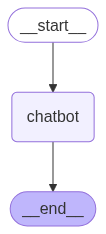

In [6]:
from langgraph.graph import END, StateGraph, add_messages
from typing import Annotated, TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage


class BasicChatBotState(TypedDict):
    "Represents the state of basic ChatBot"
    messages: Annotated[List[BaseMessage], add_messages]


def chatbot_node(state: BasicChatBotState) -> BasicChatBotState:
    "Call the llm and and get the answer."
    return {
        "messages": [llm.invoke(state["messages"])]
    }

CHATBOT = "chatbot"

graph_builder = StateGraph(BasicChatBotState)
graph_builder.add_node(CHATBOT, chatbot_node)
graph_builder.set_entry_point(CHATBOT)
graph_builder.add_edge(CHATBOT, END)

graph = graph_builder.compile()

graph

In [10]:
response = graph.invoke(
    BasicChatBotState(
        messages = [
            HumanMessage("What do you think about using FastAPI with LangGraph.")
        ]
    )
)

In [15]:
print(response["messages"][-1].content)

Using FastAPI with LangGraph can be a powerful combination for building a robust and scalable natural language processing (NLP) application. Here's a high-level overview of the benefits and considerations:

**Benefits:**

1. **FastAPI's strengths complement LangGraph**: FastAPI is a modern, fast (high-performance), web framework for building APIs with Python 3.7+ based on standard Python type hints. LangGraph, on the other hand, is a Python library for building language models and processing natural language data. Combining the two can take advantage of FastAPI's performance and LangGraph's NLP capabilities.
2. **Streamlined API development**: With FastAPI, you can quickly create APIs for interacting with your LangGraph models, making it easier to integrate NLP functionality into your application.
3. **Easy deployment**: FastAPI applications can be deployed to various platforms, such as Kubernetes, Docker, or directly with `gunicorn`.

**Considerations:**

1. **Performance**: While Fas

In [16]:
response = graph.invoke(
    BasicChatBotState(
        messages = [
            HumanMessage("What is LangGraph and why it is popular? Also tell me your cutoff date.")
        ]
    )
)

In [20]:
print(response["messages"][-1].content)

My cutoff date for knowledge is December 2023. 

LangGraph is a graph-based language model developed by the research team of the University of Cambridge. It is a type of graph neural network that can capture complex relationships between words and their meanings. LangGraph uses a graph structure to represent the relationships between words, allowing it to understand nuanced semantic relationships and nuances of language.

LangGraph is popular in the research community for several reasons:

1. **Improved representation of semantic relationships**: LangGraph's graph-based representation allows it to capture complex relationships between words that are not easily captured by traditional word embeddings.

2. **Better handling of out-of-vocabulary words**: LangGraph's ability to learn from context allows it to generalize and handle out-of-vocabulary words more effectively.

3. **Scalability**: LangGraph is designed to be scalable, making it suitable for large-scale natural language processi

### Basic Chatbot With Some Tools.

In [7]:
from langchain_tavily import TavilySearch
from pydantic import BaseModel, Field
from langchain_core.tools import tool, StructuredTool
from datetime import datetime


class InputSchema(BaseModel):
    """
    InputSchema defines the input structure for numerical operations, containing two fields:
    - num_1: The first number (integer or float).
    - num_2: The second number (integer or float).
    """
    num_1: int | float = Field(description = "The first number (integer or float) eg. 8 or 8.5")
    num_2: int | float = Field(description = "The second number (integer or float) eg. 8 or 8.5")


@tool(
    name_or_callable = "date_time", 
    description = "Use when you need to get current date and time.",
)
def get_current_date():
    """Returns the current Date."""
    return datetime.now().strftime("%Y-%m-%d %I:%M:%S, %p")



@tool(
    name_or_callable = "addition",
    description = "Use when you need to perform addition operation.",
    args_schema = InputSchema
)
def addition(num_1: int | float, num_2: int | float) -> float:
    """Returns the addition of two numbers."""
    return num_1 + num_2



@tool(
    name_or_callable = "multiplication",
    description = "Use when you need to perform multiplication operation.",
    args_schema = InputSchema
)
def multiplication(num_1: int | float, num_2: int | float) -> float:
    """Returns the multiplication of two numbers."""
    return num_1 * num_2



@tool(
    name_or_callable = "subtraction",
    description =  "Use when you need to perform subtraction operation.",
    args_schema = InputSchema
)
def subtraction(num_1: int | float, num_2: int | float) -> float:
    """Returns the subtraction of two numbers."""
    return num_1 - num_2


@tool(
    name_or_callable = "division",
    description = "Use when you need to perform division operation.",
    args_schema = InputSchema
)

def division(num_1: int | float, num_2: int | float) -> float:
    """Returns the division of two numbers."""
    if num_2 == 0:
        raise ValueError("Division by zero is not allowed.")
    return num_1 / num_2


tavily_search = TavilySearch(
    tavily_api_key = settings.tavily_api_key,
    max_results = 2
)

available_tools: List[StructuredTool | TavilySearch] = [
    addition, subtraction, multiplication, division, get_current_date, tavily_search
]

### We bind this tools to our LLM

In [8]:
llm_with_tools = llm.bind_tools(tools = available_tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000234B77AFE00>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000234B7938AD0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'), max_tokens=2000), kwargs={'tools': [{'type': 'function', 'function': {'name': 'addition', 'description': 'Use when you need to perform addition operation.', 'parameters': {'properties': {'num_1': {'anyOf': [{'type': 'integer'}, {'type': 'number'}], 'description': 'The first number (integer or float) eg. 8 or 8.5'}, 'num_2': {'anyOf': [{'type': 'integer'}, {'type': 'number'}], 'description': 'The second number (integer or float) eg. 8 or 8.5'}}, 'required': ['num_1', 'num_2'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'subtraction', 'description': 'Use when you need to perform subtraction operation.', 'parameters': {'properties': {'num_1': {'anyOf': [{'type': 'integer'}, {'

In [9]:
print(llm_with_tools.model_dump_json(indent = 4))

{
    "name": null,
    "bound": {
        "name": null,
        "disable_streaming": false,
        "model_name": "llama-3.1-8b-instant",
        "temperature": 0.7,
        "stop": null,
        "reasoning_format": null,
        "reasoning_effort": null,
        "model_kwargs": {},
        "groq_api_key": "**********",
        "groq_api_base": null,
        "groq_proxy": null,
        "request_timeout": null,
        "max_retries": 2,
        "streaming": false,
        "n": 1,
        "max_tokens": 2000,
        "service_tier": "on_demand",
        "default_headers": null,
        "default_query": null,
        "http_client": null,
        "http_async_client": null
    },
    "kwargs": {
        "tools": [
            {
                "type": "function",
                "function": {
                    "name": "addition",
                    "description": "Use when you need to perform addition operation.",
                    "parameters": {
                        "properties": 

In [43]:
response = llm_with_tools.invoke("what is the sum of 90.78 and 465.43")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tp21n611n', 'function': {'arguments': '{"num_1":90.78,"num_2":465.43}', 'name': 'addition'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 2356, 'total_tokens': 2383, 'completion_time': 0.036, 'prompt_time': 0.30879163, 'queue_time': 0.052429521000000034, 'total_time': 0.34479163}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3f242eca-7d10-44e0-ad88-85db247b7239-0', tool_calls=[{'name': 'addition', 'args': {'num_1': 90.78, 'num_2': 465.43}, 'id': 'tp21n611n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2356, 'output_tokens': 27, 'total_tokens': 2383})

In [44]:
print(response.content)

In [45]:
print(response.tool_calls)

[{'name': 'addition', 'args': {'num_1': 90.78, 'num_2': 465.43}, 'id': 'tp21n611n', 'type': 'tool_call'}]


In [49]:
response = llm_with_tools.invoke("what is the product of 90.78 and 465.43")

In [50]:
print(response.tool_calls)

[{'name': 'multiplication', 'args': {'num_1': 90.78, 'num_2': 465.43}, 'id': 'vbqqrqknr', 'type': 'tool_call'}]


In [51]:
response = llm_with_tools.invoke("what is LangGraph?")
print(response)

content='' additional_kwargs={'tool_calls': [{'id': 'at1rf4wa8', 'function': {'arguments': '{"query":"LangGraph","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 2347, 'total_tokens': 2370, 'completion_time': 0.051112056, 'prompt_time': 0.191217512, 'queue_time': 0.052991334, 'total_time': 0.242329568}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--b515eb1b-0fbc-48ff-9619-1b8555a5f408-0' tool_calls=[{'name': 'tavily_search', 'args': {'query': 'LangGraph', 'topic': 'general'}, 'id': 'at1rf4wa8', 'type': 'tool_call'}] usage_metadata={'input_tokens': 2347, 'output_tokens': 23, 'total_tokens': 2370}


In [52]:
response.tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'LangGraph', 'topic': 'general'},
  'id': 'at1rf4wa8',
  'type': 'tool_call'}]

In [53]:
response = llm_with_tools.invoke("what is the current temperature in chennai?")
print(response, end = "\n")
print(response.tool_calls)

content='' additional_kwargs={'tool_calls': [{'id': '39ec2e5zs', 'function': {'arguments': '{"query":"current temperature in chennai","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': '81v8en874', 'function': {'arguments': '{}', 'name': 'date_time'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 2351, 'total_tokens': 2385, 'completion_time': 0.082211284, 'prompt_time': 0.189937938, 'queue_time': 0.052965758, 'total_time': 0.272149222}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--938e800b-643d-409b-905b-0b8a51f56f68-0' tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current temperature in chennai', 'topic': 'news'}, 'id': '39ec2e5zs', 'type': 'tool_call'}, {'name': 'date_time', 'args': {}, 'id': '81v8en874', 'type': 'tool_call'}] usage_metadata={'input_tokens': 2351, 'output_tokens': 34

## Utilize LangGraph's ToolNode to Execute the tools. 

In [55]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools = available_tools)
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'addition': StructuredTool(name='addition', description='Use when you need to perform addition operation.', args_schema=<class '__main__.InputSchema'>, func=<function addition at 0x00000210CF7E1C60>), 'subtraction': StructuredTool(name='subtraction', description='Use when you need to perform subtraction operation.', args_schema=<class '__main__.InputSchema'>, func=<function subtraction at 0x00000210CF7E0220>), 'multiplication': StructuredTool(name='multiplication', description='Use when you need to perform multiplication operation.', args_schema=<class '__main__.InputSchema'>, func=<function multiplication at 0x00000210CF7E0400>), 'division': StructuredTool(name='division', description='Use when you need to perform division operation.', args_schema=<class '__main__.InputSchema'>, func=<function division at 0x00000210CF7E22A0>), 'date_time': Struc

In [62]:
print(type(tool_node))

<class 'langgraph.prebuilt.tool_node.ToolNode'>


### Let's test the ToolNode with a sample LLM Tool Call

In [57]:
response = llm_with_tools.invoke("what is the sum of 908.657 and 87.365")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ret7ca176', 'function': {'arguments': '{"num_1":908.657,"num_2":87.365}', 'name': 'addition'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 2356, 'total_tokens': 2383, 'completion_time': 0.045458666, 'prompt_time': 0.546220925, 'queue_time': 0.05245337400000005, 'total_time': 0.591679591}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0ff61786-35d3-4869-abb0-5aa0817f4ddd-0', tool_calls=[{'name': 'addition', 'args': {'num_1': 908.657, 'num_2': 87.365}, 'id': 'ret7ca176', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2356, 'output_tokens': 27, 'total_tokens': 2383})

In [59]:
sample_messages_state: BasicChatBotState = BasicChatBotState(
    messages = [
        HumanMessage(content = "what is the sum of 908.657 and 87.365"),
        AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ret7ca176', 'function': {'arguments': '{"num_1":908.657,"num_2":87.365}', 'name': 'addition'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 2356, 'total_tokens': 2383, 'completion_time': 0.045458666, 'prompt_time': 0.546220925, 'queue_time': 0.05245337400000005, 'total_time': 0.591679591}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0ff61786-35d3-4869-abb0-5aa0817f4ddd-0', tool_calls=[{'name': 'addition', 'args': {'num_1': 908.657, 'num_2': 87.365}, 'id': 'ret7ca176', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2356, 'output_tokens': 27, 'total_tokens': 2383})
    ]
)
sample_messages_state

{'messages': [HumanMessage(content='what is the sum of 908.657 and 87.365', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ret7ca176', 'function': {'arguments': '{"num_1":908.657,"num_2":87.365}', 'name': 'addition'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 2356, 'total_tokens': 2383, 'completion_time': 0.045458666, 'prompt_time': 0.546220925, 'queue_time': 0.05245337400000005, 'total_time': 0.591679591}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0ff61786-35d3-4869-abb0-5aa0817f4ddd-0', tool_calls=[{'name': 'addition', 'args': {'num_1': 908.657, 'num_2': 87.365}, 'id': 'ret7ca176', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2356, 'output_tokens': 27, 'total_tokens': 2383})]}

In [60]:
tool_call_result = tool_node.invoke(sample_messages_state)

In [61]:
tool_call_result

{'messages': [ToolMessage(content='996.022', name='addition', tool_call_id='ret7ca176')]}

#### Now we get the final result from the ToolNode. The result we get it as ToolMessage. The content hold the final answer.

## Now Create a Graph with a ToolNode, This ensure our ChatBot has some tools that it can use whenever needed.

### Copy and paste the same code from simple chatbot implementation

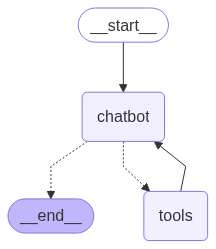

In [73]:
from langgraph.graph import END, StateGraph, add_messages
from typing import Annotated, TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langgraph.prebuilt import ToolNode

# Bind all the custom tools to the LLM.
llm_with_tools = llm.bind_tools(tools = available_tools)
# Create a ToolNode to execute appropriate tools.
tool_node: ToolNode = ToolNode(
    tools = available_tools,
    messages_key = "messages"
)

CHATBOT = "chatbot"
TOOLS = "tools"


class BasicChatBotState(TypedDict):
    "Represents the state of basic ChatBot"
    messages: Annotated[List[BaseMessage], add_messages]


def chatbot_node(state: BasicChatBotState) -> BasicChatBotState:
    """Execute tools and return the results."""
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tool_executor_node(state: BasicChatBotState) -> BasicChatBotState:
    tool_response: List[ToolMessage] = tool_node.invoke(state["messages"])
    return {
        "messages": tool_response
    }    

def tool_call_required(state: BasicChatBotState) -> BasicChatBotState:
    """Check if the last message requires tool calls."""
    last_ai_message: AIMessage = state["messages"][-1]
    if last_ai_message.tool_calls:
        return TOOLS
    return END 


# Build the Graph Workflow.
graph_builder = StateGraph(BasicChatBotState)
graph_builder.add_node(CHATBOT, chatbot_node)
graph_builder.add_node(TOOLS, tool_executor_node)
graph_builder.set_entry_point(CHATBOT)
graph_builder.add_edge(TOOLS, CHATBOT)
graph_builder.add_conditional_edges(
    CHATBOT,
    tool_call_required,
    path_map = {
        TOOLS: TOOLS,
        END: END
    }
)
graph_builder.add_edge(CHATBOT, END)

graph = graph_builder.compile()

graph

In [74]:
response: BasicChatBotState = graph.invoke(
    BasicChatBotState(
        messages = [
            HumanMessage("Hi, this is Nagarjun, Could you tell me what is the product of 768.0909 and 8.454")
        ]
    )
) 

In [77]:
response["messages"]

[HumanMessage(content='Hi, this is Nagarjun, Could you tell me what is the product of 768.0909 and 8.454', additional_kwargs={}, response_metadata={}, id='e3c51707-2c48-4954-9d48-741102896ec5'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'jvtjtc2pg', 'function': {'arguments': '{"num_1":768.0909,"num_2":8.454}', 'name': 'multiplication'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 2368, 'total_tokens': 2397, 'completion_time': 0.038792865, 'prompt_time': 0.156068998, 'queue_time': 0.053239958000000004, 'total_time': 0.194861863}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d6a652d8-2d41-4c41-9d78-1ae83be19803-0', tool_calls=[{'name': 'multiplication', 'args': {'num_1': 768.0909, 'num_2': 8.454}, 'id': 'jvtjtc2pg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2368, 'output_tokens': 

In [78]:
response: BasicChatBotState = graph.invoke(
    BasicChatBotState(
        messages = [
            HumanMessage("Hi, this is Nagarjun.")
        ]
    )
) 
response

{'messages': [HumanMessage(content='Hi, this is Nagarjun.', additional_kwargs={}, response_metadata={}, id='a9fd042a-5f38-4e13-9f02-1afcccda0558'),
  AIMessage(content='Hello Nagarjun. How are you today? Is there anything I can help you with?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 2349, 'total_tokens': 2368, 'completion_time': 0.035364857, 'prompt_time': 0.325201939, 'queue_time': 0.05240837100000001, 'total_time': 0.360566796}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--7cecb5e5-c0c9-4252-8e9f-889fb4b03d9d-0', usage_metadata={'input_tokens': 2349, 'output_tokens': 19, 'total_tokens': 2368})]}

In [83]:
%%time
response: BasicChatBotState = graph.invoke(
    BasicChatBotState(
        messages = [
            HumanMessage("What is LangGraph?")
        ]
    )
) 
response

CPU times: total: 31.2 ms
Wall time: 3.52 s


{'messages': [HumanMessage(content='What is LangGraph?', additional_kwargs={}, response_metadata={}, id='8461297c-24b2-4ee4-8bb5-405de3b3fc0a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9svdw4w0a', 'function': {'arguments': '{"query":"LangGraph","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 2347, 'total_tokens': 2370, 'completion_time': 0.112776415, 'prompt_time': 0.333663968, 'queue_time': 0.05502443000000001, 'total_time': 0.446440383}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--23b7f1f9-13c7-434c-bbb4-0986bc154ea8-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'LangGraph', 'topic': 'general'}, 'id': '9svdw4w0a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2347, 'output_tokens': 23, 'total_tokens': 2370}),
  ToolMess

### ChatBot With Memory/CheckPointer

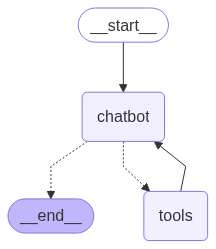

In [105]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END, StateGraph, add_messages
from typing import Annotated, TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langgraph.prebuilt import ToolNode


# LLM initialization.
llm = ChatGroq(
    groq_api_key = settings.groq_api_key,
    temperature = 0,
    max_tokens = 3000,
    model = "deepseek-r1-distill-llama-70b" 
)

# Bind all the custom tools to the LLM.
llm_with_tools = llm.bind_tools(tools = available_tools)
# Create a ToolNode to execute appropriate tools.
tool_node: ToolNode = ToolNode(
    tools = available_tools,
    messages_key = "messages"
)

CHATBOT = "chatbot"
TOOLS = "tools"


class BasicChatBotState(TypedDict):
    "Represents the state of basic ChatBot"
    messages: Annotated[List[BaseMessage], add_messages]


def chatbot_node(state: BasicChatBotState) -> BasicChatBotState:
    """Execute tools and return the results."""
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tool_executor_node(state: BasicChatBotState) -> BasicChatBotState:
    tool_response: List[ToolMessage] = tool_node.invoke(state["messages"])
    return {
        "messages": tool_response
    }    

def tool_call_required(state: BasicChatBotState) -> BasicChatBotState:
    """Check if the last message requires tool calls."""
    last_ai_message: AIMessage = state["messages"][-1]
    if last_ai_message.tool_calls:
        return TOOLS
    return END 


# Build the Graph Workflow.
graph_builder = StateGraph(BasicChatBotState)
graph_builder.add_node(CHATBOT, chatbot_node)
graph_builder.add_node(TOOLS, tool_executor_node)
graph_builder.set_entry_point(CHATBOT)
graph_builder.add_edge(TOOLS, CHATBOT)
graph_builder.add_conditional_edges(
    CHATBOT,
    tool_call_required,
    path_map = {
        TOOLS: TOOLS,
        END: END
    }
)
graph_builder.add_edge(CHATBOT, END)

# Memory
memory = InMemorySaver()

graph = graph_builder.compile(checkpointer = memory)

graph

In [106]:
while True:
    user_input: str = input("Human: ")
    print(f"Human: {user_input}", end = "\n\n")
    if user_input.lower() in ["exit", "quit", "end"]:
        break
    response: BasicChatBotState = graph.invoke(
        BasicChatBotState(
            messages = [
                HumanMessage(content = user_input)
            ],
        ), 
        config = {
            "configurable": {
                "thread_id": "my_thread"
            }
        } 
    ) 
    answer: str = response["messages"][-1].content
    print(f"AI: {answer}", end = "\n\n")



Human: Hi, this is Nagarjun. I'm an AI Engineer.

AI: It seems like you're introducing yourself, but I'm not sure how I can assist you yet. Could you please provide more details about what you need help with? Whether it's a math problem, a search query, or something else, feel free to ask!

Human: what's the current time ?

AI: The current time is **2025-07-28 02:06:22 PM**.

Human: what is the  result of 8976/0.9989878 = ?

AI: The result of dividing 8976 by 0.9989878 is **8985.094712868366**.

Human: what is my first question?

AI: Could you clarify what you mean by "my first question"? Are you referring to the first message you sent, which was introducing yourself, or the first actual question you asked about the current time? Let me know so I can assist you better!

Human: why LangChain and LangGraph are so popular?

AI: LangChain and LangGraph are popular due to their unique strengths in the AI development ecosystem:

1. **LangChain**:
   - **Ease of Use**: LangChain is known for 

### Now see, we achieve the memory. 

In [107]:
snapshot = graph.get_state(
    config = {
        "configurable": {
            "thread_id": "my_thread"
        }
    }
)

In [109]:
snapshot.values

{'messages': [HumanMessage(content="Hi, this is Nagarjun. I'm an AI Engineer.", additional_kwargs={}, response_metadata={}, id='be1849f8-615c-4f9b-852a-a5767f3fed4b'),
  AIMessage(content="It seems like you're introducing yourself, but I'm not sure how I can assist you yet. Could you please provide more details about what you need help with? Whether it's a math problem, a search query, or something else, feel free to ask!", additional_kwargs={'reasoning_content': "Okay, so I'm trying to figure out how to use the tools provided to help with the user's query. The user mentioned they're an AI Engineer, but didn't specify what they need assistance with. Since the tools include functions for basic arithmetic operations, date/time, and a search engine, I should consider which of these might be useful.\n\nFirst, I need to understand the user's intent. If they're introducing themselves, maybe they don't need immediate assistance but might have a question coming up. Since they didn't ask anythi

How checkpointing works in LangGraph and how the LLM uses it to remember conversations.

## How Checkpointing Works in LangGraph

**1. Where is it stored?**
`InMemorySaver()` stores checkpoints in **RAM memory** of your Python process. It's not persistent - when your program ends, the memory is lost. The checkpoints are stored as serialized state snapshots, not in your `state["messages"]` directly.

**2. What gets stored?**
Every time a node completes execution, LangGraph automatically saves the **entire state** as a checkpoint. In your case, this means the complete `messages` list gets serialized and stored with a unique checkpoint ID.

**3. How does the LLM use this memory?**
Here's the crucial part: **The LLM itself doesn't directly access the checkpointer**. Instead, LangGraph uses the `thread_id` to:
- Retrieve the last checkpoint for that thread
- Load the previous `state["messages"]` 
- **Append your new message** to the existing messages list (thanks to the `add_messages` reducer)
- Pass the **complete conversation history** to the LLM

## The Memory Flow

When you invoke the graph with a `thread_id`, here's what happens:

1. **Retrieval**: LangGraph looks up the last checkpoint for "my_thread"
2. **State Reconstruction**: Loads the previous `messages: [msg1, msg2, msg3, ...]`
3. **Message Addition**: Your new `HumanMessage` gets added: `[msg1, msg2, msg3, ..., new_msg]`
4. **LLM Context**: The LLM receives the **entire message history**, not just your current input
5. **New Checkpoint**: After processing, the updated state gets saved as a new checkpoint


This creates a fresh state with only the current message. To properly use memory, you should invoke with just the new message and let LangGraph handle the state reconstruction:

```python
response = graph.invoke(
    {"messages": [HumanMessage(content = user_input)]},  # Just the new message
    config = {"configurable": {"thread_id": "my_thread"}}
)
```

## Memory Persistence Options

- **InMemorySaver**: RAM only, lost when program ends
- **SqliteSaver**: Persists to SQLite database file
- **PostgresSaver**: Persists to PostgreSQL database

The checkpointer acts as a "time machine" for your conversation state, allowing the LLM to have context about the entire conversation history, not just the current input.

In [110]:
for msg in snapshot.values["messages"]:
    print(msg)

content="Hi, this is Nagarjun. I'm an AI Engineer." additional_kwargs={} response_metadata={} id='be1849f8-615c-4f9b-852a-a5767f3fed4b'
content="It seems like you're introducing yourself, but I'm not sure how I can assist you yet. Could you please provide more details about what you need help with? Whether it's a math problem, a search query, or something else, feel free to ask!" additional_kwargs={'reasoning_content': "Okay, so I'm trying to figure out how to use the tools provided to help with the user's query. The user mentioned they're an AI Engineer, but didn't specify what they need assistance with. Since the tools include functions for basic arithmetic operations, date/time, and a search engine, I should consider which of these might be useful.\n\nFirst, I need to understand the user's intent. If they're introducing themselves, maybe they don't need immediate assistance but might have a question coming up. Since they didn't ask anything specific yet, perhaps I should prompt them

## Create a new thread to interact with a Graph.

In [101]:
response: BasicChatBotState = graph.invoke(
    BasicChatBotState(
        messages = [
            HumanMessage("What is the temperature in chennai now?")
        ],
    ),
    config = {
        "configurable": {
            "thread_id": "thread_2"
        }
    }
)
response

{'messages': [HumanMessage(content='What is the temperature in chennai now?', additional_kwargs={}, response_metadata={}, id='bf134153-8ff1-44eb-b83b-3c8005751959'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'dfdw5kk4m', 'function': {'arguments': '{"query":"current temperature in chennai now","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 2351, 'total_tokens': 2378, 'completion_time': 0.069227334, 'prompt_time': 0.242482064, 'queue_time': 0.05240523600000002, 'total_time': 0.311709398}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--31acbf1e-b461-486d-8a1c-c6bc947f6cc2-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current temperature in chennai now', 'topic': 'news'}, 'id': 'dfdw5kk4m', 'type': 'tool_call'}], usage_metadata={'input_token

In [102]:
print(response["messages"][-1].content)

The current temperature in Chennai is around 83°F (28°C) according to AccuWeather.


In [103]:
print(graph.get_state(
    config = {
        "configurable": {
            "thread_id": "thread_2"
            }
        }
    )
)

StateSnapshot(values={'messages': [HumanMessage(content='What is the temperature in chennai now?', additional_kwargs={}, response_metadata={}, id='bf134153-8ff1-44eb-b83b-3c8005751959'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'dfdw5kk4m', 'function': {'arguments': '{"query":"current temperature in chennai now","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 2351, 'total_tokens': 2378, 'completion_time': 0.069227334, 'prompt_time': 0.242482064, 'queue_time': 0.05240523600000002, 'total_time': 0.311709398}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--31acbf1e-b461-486d-8a1c-c6bc947f6cc2-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current temperature in chennai now', 'topic': 'news'}, 'id': 'dfdw5kk4m', 'type': 'tool_call'}], usage_met

In [104]:
response: BasicChatBotState = graph.invoke(
    BasicChatBotState(
        messages = [
            HumanMessage("What is my last question?")
        ],
    ),
    config = {
        "configurable": {
            "thread_id": "thread_2"
        }
    }
)
response

{'messages': [HumanMessage(content='What is the temperature in chennai now?', additional_kwargs={}, response_metadata={}, id='bf134153-8ff1-44eb-b83b-3c8005751959'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'dfdw5kk4m', 'function': {'arguments': '{"query":"current temperature in chennai now","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 2351, 'total_tokens': 2378, 'completion_time': 0.069227334, 'prompt_time': 0.242482064, 'queue_time': 0.05240523600000002, 'total_time': 0.311709398}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--31acbf1e-b461-486d-8a1c-c6bc947f6cc2-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current temperature in chennai now', 'topic': 'news'}, 'id': 'dfdw5kk4m', 'type': 'tool_call'}], usage_metadata={'input_token

### Since InMemorySaver lost all the memory, We SQLiteSaver to make it persist.

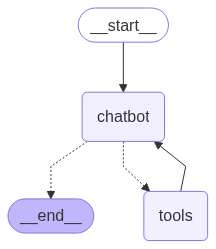

In [10]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph, add_messages
from typing import Annotated, TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langgraph.prebuilt import ToolNode
import sqlite3


# LLM initialization.
llm = ChatGroq(
    groq_api_key = settings.groq_api_key,
    temperature = 0,
    max_tokens = 3000,
    model = "deepseek-r1-distill-llama-70b" 
)

# Bind all the custom tools to the LLM.
llm_with_tools = llm.bind_tools(tools = available_tools)
# Create a ToolNode to execute appropriate tools.
tool_node: ToolNode = ToolNode(
    tools = available_tools,
    messages_key = "messages"
)

CHATBOT = "chatbot"
TOOLS = "tools"


class BasicChatBotState(TypedDict):
    "Represents the state of basic ChatBot"
    messages: Annotated[List[BaseMessage], add_messages]


def chatbot_node(state: BasicChatBotState) -> BasicChatBotState:
    """Execute tools and return the results."""
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tool_executor_node(state: BasicChatBotState) -> BasicChatBotState:
    tool_response: List[ToolMessage] = tool_node.invoke(state["messages"])
    return {
        "messages": tool_response
    }    

def tool_call_required(state: BasicChatBotState) -> BasicChatBotState:
    """Check if the last message requires tool calls."""
    last_ai_message: AIMessage = state["messages"][-1]
    if last_ai_message.tool_calls:
        return TOOLS
    return END 


# Build the Graph Workflow.
graph_builder = StateGraph(BasicChatBotState)
graph_builder.add_node(CHATBOT, chatbot_node)
graph_builder.add_node(TOOLS, tool_executor_node)
graph_builder.set_entry_point(CHATBOT)
graph_builder.add_edge(TOOLS, CHATBOT)
graph_builder.add_conditional_edges(
    CHATBOT,
    tool_call_required,
    path_map = {
        TOOLS: TOOLS,
        END: END
    }
)
graph_builder.add_edge(CHATBOT, END)

# Memory
conn: sqlite3.Connection = sqlite3.connect(
    "checkpoints.sqlite", 
    check_same_thread = False
)

memory = SqliteSaver(conn)

graph = graph_builder.compile(checkpointer = memory)

graph

In [115]:
while True:
    user_input: str = input("Human: ")
    print(f"Human: {user_input}", end = "\n\n")
    if user_input.lower() in ["exit", "quit", "end"]:
        break
    response: BasicChatBotState = graph.invoke(
        BasicChatBotState(
            messages = [
                HumanMessage(content = user_input)
            ],
        ), 
        config = {
            "configurable": {
                "thread_id": "first_thread"
            }
        } 
    ) 
    answer: str = response["messages"][-1].content
    print(f"AI: {answer}", end = "\n\n")



Human: Hi, this is Nagarjun. You?

AI: Hello, Nagarjun! How can I assist you today?

Human: what is the result of 89 * 1.5

AI: The result of 89 multiplied by 1.5 is 133.5.

Human: what is my last question?

AI: Your last question was about calculating the result of 89 multiplied by 1.5.

Human: exit



In [11]:
# Ask for the name, and test whether it remembers.

response: BasicChatBotState = graph.invoke(
    BasicChatBotState(
        messages = [
            HumanMessage("When coolie movie will releases?")
        ]
    ),
    config = {
        "configurable": {
            "thread_id": "first_thread"
        }
    }
)
response

{'messages': [HumanMessage(content='Hi, this is Nagarjun. You?', additional_kwargs={}, response_metadata={}, id='65a4c432-2851-40c1-8fc4-b24819fe9813'),
  AIMessage(content='Hello, Nagarjun! How can I assist you today?', additional_kwargs={'reasoning_content': 'Alright, the user greeted me with "Hi, this is Nagarjun. You?" which seems like a friendly hello. Since I\'m an AI, I should respond in a welcoming manner. I want to make sure they feel comfortable asking for help. I\'ll keep it simple and open-ended to encourage them to share what they need assistance with.\n'}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 2107, 'total_tokens': 2193, 'completion_time': 0.440426181, 'prompt_time': 0.159865975, 'queue_time': 0.05606192800000001, 'total_time': 0.600292156}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ee2a873c-af0b-4bc8-b67e-29c

In [13]:
print(response["messages"][-1].content)

The movie *Coolie* is scheduled to release on **August 14, 2025**, in theaters. This information is confirmed by multiple sources, including Wikipedia and IMDb. The film will be released in Tamil, with dubbed versions in Telugu, Hindi, and Kannada.
